# Data Exploration

### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import librosa
from collections import defaultdict
import matplotlib.pyplot as plt
from PIL import Image
import IPython
import IPython.display as ipd

In [2]:
# Data file path

ravdess_path = 'data'
ravdess_dir = os.listdir(ravdess_path)

In [3]:
# Conversion into human understandable values 

emotions_convert = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

stetment_convert = {
    '01':'Kids are talking by the door',
    '02':'Dogs are sitting by the door'
}

### DataFrame containing file location and audio attributes 

In [4]:
gender_arr = []
path_arr = []
emotion_arr = []
statement_arr = []

for actor in ravdess_dir:
    
    if 'Actor' in actor: 
        actor_files = os.listdir(os.path.join(ravdess_path, actor))
        for audio_file in actor_files:                
            file_name = audio_file.split('.')[0]
            emotion_key = file_name.split('-')[2]
            gender_identifier = int(file_name.split('-')[6])
            statement_id = file_name.split('-')[4]
            path_arr.append(f"{ravdess_path}/{actor}/{audio_file}")

            if gender_identifier % 2 == 0:
                gender_arr.append("female")
            else:
                gender_arr.append("male")
            emotion_arr.append(emotions_convert[emotion_key])
            statement_arr.append(stetment_convert[statement_id])
             
df = pd.concat([
    pd.DataFrame(path_arr, columns = ['path']),
    pd.DataFrame(gender_arr, columns = ['gender']),
    pd.DataFrame(emotion_arr, columns = ['emotion']),
    pd.DataFrame(statement_arr, columns = ['statement'])
], axis = 1)

df

,path,gender,emotion,statement
0,data/Actor_16/03-01-05-01-02-01-16.wav,female,angry,Dogs are sitting by the door
1,data/Actor_16/03-01-06-01-02-02-16.wav,female,fearful,Dogs are sitting by the door
2,data/Actor_16/03-01-06-02-01-02-16.wav,female,fearful,Kids are talking by the door
3,data/Actor_16/03-01-05-02-01-01-16.wav,female,angry,Kids are talking by the door
4,data/Actor_16/03-01-07-01-01-01-16.wav,female,disgust,Kids are talking by the door
...,...,...,...,...
1435,data/Actor_08/03-01-03-02-02-02-08.wav,female,happy,Dogs are sitting by the door
1436,data/Actor_08/03-01-03-01-01-02-08.wav,female,happy,Kids are talking by the door
1437,data/Actor_08/03-01-02-02-01-01-08.wav,female,calm,Kids are talking by the door
1438,data/Actor_08/03-01-02-01-02-01-08.wav,female,calm,Dogs are sitting by the door


In [5]:
male_actors = df[(df['gender'] == 'male') & (df['statement'] == 'Kids are talking by the door')]
male_angry = male_actors[male_actors['emotion'] == 'angry']
male_happy = male_actors[male_actors['emotion'] == 'happy']

### Method for constructing spectogram

In [6]:
dict_emotion_arrs = {
    'angry': [],
    'happy': [],
    'sad': [], 
    'calm': [],
    'fearful' : [],
    'disgust' : [],
    'surprised' : [], 
    'neutral' : []
}

dict_emotions_waveFile =  {
    'angry': [],
    'happy': [],
    'sad': [], 
    'calm': [],
    'fearful' : [],
    'disgust' : [],
    'surprised' : [], 
    'neutral' : []
}

## Constructing spectogram for each audio file

In [7]:
def construct_spectogram(PATH):
    
    original_audio, sample_rate = librosa.load(PATH, sr=44100)
    y, sr = librosa.load(PATH, sr=44100)
    
    mfcc = librosa.feature.mfcc(y=original_audio, sr=sample_rate)
    y, sr = librosa.load(PATH, sr = sample_rate)
    sgram = librosa.stft(y)
    sgram_mag, _ = librosa.magphase(sgram)
    mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sample_rate)
    mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
    
    emotion_id = emotions_convert[PATH.split('-')[2]]

    dict_emotion_arrs[emotion_id].append(mel_sgram)
    
    dict_emotions_waveFile[emotion_id].append(original_audio)

    return mel_sgram

In [8]:
# construct_spectogram(male_angry.iloc[0]['path'])

In [9]:
# male_angry['path'].apply(construct_spectogram)

In [10]:
df['path'].apply(construct_spectogram) 

0       [[22.881767, 22.881767, 22.881767, 22.881767, ...
1       [[24.172699, 24.172699, 24.172699, 24.172699, ...
2       [[37.62214, 37.62214, 37.62214, 37.62214, 37.6...
3       [[34.17698, 34.17698, 34.17698, 34.17698, 34.1...
4       [[13.969704, 13.969704, 13.969704, 13.969704, ...
                              ...                        
1435    [[36.51407, 48.99385, 49.447002, 39.938538, 43...
1436    [[33.509773, 37.279495, 40.09108, 41.370415, 4...
1437    [[36.23403, 38.54433, 30.25328, 28.617416, 23....
1438    [[44.199326, 41.04016, 45.946938, 46.771263, 4...
1439    [[42.591698, 41.05215, 48.840874, 45.67775, 42...
Name: path, Length: 1440, dtype: object

In [11]:
dict_emotion_arrs.keys()

dict_keys(['angry', 'happy', 'sad', 'calm', 'fearful', 'disgust', 'surprised', 'neutral'])

## Taking mean of spectograms by class

In [12]:
# spectogram representation of angry files 
from collections import defaultdict

means_of_emotions = defaultdict(list)

for emotion in dict_emotion_arrs.keys(): 
    emotion_array = dict_emotion_arrs[emotion]
    emotion_arr_means = [specto.mean() for specto in emotion_array]
    means_of_emotions[emotion].append(emotion_arr_means)

In [13]:
means_of_emotions['sad'][0][:20]

[24.60692,
 30.47356,
 24.744541,
 29.772642,
 29.120249,
 24.786081,
 27.567823,
 24.553833,
 37.175743,
 20.970274,
 30.683292,
 22.560183,
 22.176414,
 33.513657,
 22.180153,
 35.169647,
 24.0776,
 41.09573,
 26.213274,
 39.894516]

## Histogram of means 

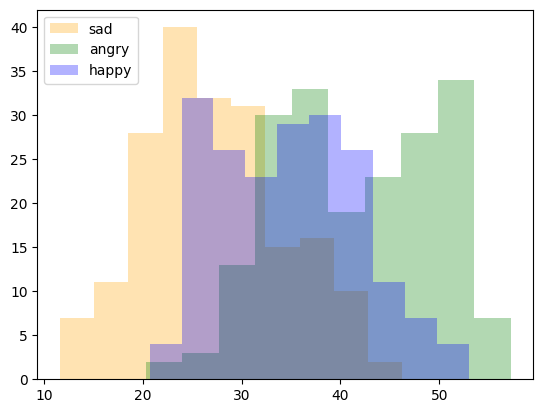

In [14]:
plt.hist(means_of_emotions['sad'][0], color='orange', alpha=0.30, label='sad')
# plt.hist(means_of_emotions['calm'][0], color = 'red', alpha=0.30)
plt.hist(means_of_emotions['angry'][0], color = 'green', alpha=0.30, label='angry')
plt.hist(means_of_emotions['happy'][0], color = 'blue', alpha=0.30, label='happy')

# Add a legend
plt.legend()

# Show the plot
plt.show()

### Interpretation of Histogram

What does the numbers in the array actually mean? 

A number at a given point represents the decible. As a result, a spectogram with (comparatively) high mean value means that on average the audio file was louder than others. A spectogram with low mean values indicates that on average the audio file was quieter than others. 

In [15]:
len(dict_emotion_arrs['angry'])

192

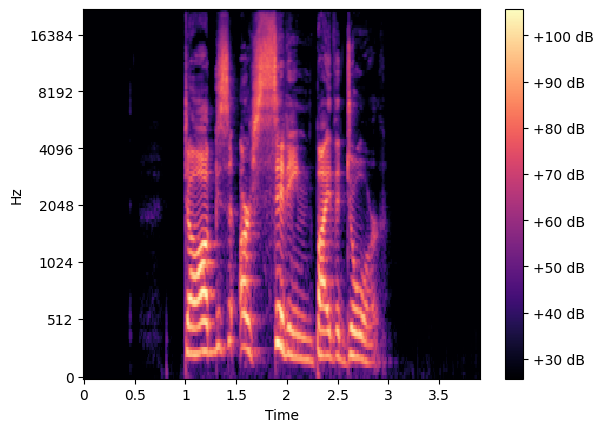

In [16]:
angry_specto = dict_emotion_arrs['angry'][5]
librosa.display.specshow(angry_specto, sr=44100, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

In [17]:
y = dict_emotions_waveFile['angry'][5]
# fig = librosa.display.waveshow(y, sr=44100)
ipd.Audio(y, rate=44100)

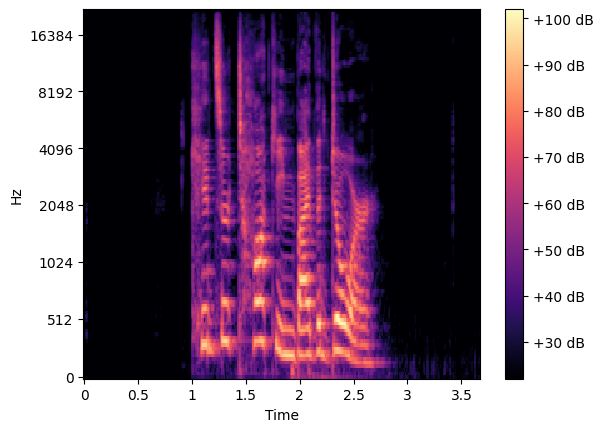

In [18]:
happy_specto = dict_emotion_arrs['happy'][1]

librosa.display.specshow(happy_specto, sr=44100, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

In [19]:
y = dict_emotions_waveFile['happy'][1]
# fig = librosa.display.waveshow(y, sr=44100)
ipd.Audio(y, rate=44100)

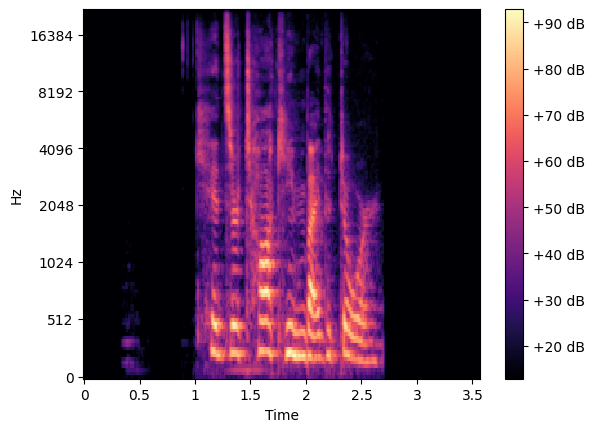

In [20]:
sad_specto = dict_emotion_arrs['sad'][5]

librosa.display.specshow(sad_specto, sr=44100, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

In [21]:
y = dict_emotions_waveFile['sad'][5]
# fig = librosa.display.waveshow(y, sr=44100)
ipd.Audio(y, rate=44100)

In [22]:
angry_10db_cutout = pd.DataFrame(dict_emotion_arrs['angry'][0]).loc[ :,86:260].values.mean()
sad_10db_cutout = pd.DataFrame(dict_emotion_arrs['sad'][0]).loc[ :,86:260].values.mean()
angry_10db_cutout, sad_10db_cutout

(48.564426, 32.63928)

In [23]:
t = dict_emotion_arrs['angry'][5]

In [24]:
import numpy as np
from scipy.signal import find_peaks

def find_peak_(data):
    # Find peaks
    peaks, _ = find_peaks(data)
    # Calculate distances between consecutive peaks
    distances = np.diff(peaks)
    return distances, peaks

In [25]:
angry_dist_files = []

for file in dict_emotion_arrs['angry']:  
    dist_file = np.array([])
    transposed_data = np.transpose(data)    
    for lst in file:
        distances_i, peaks_i = find_peak_(lst)
        dist_file = np.append(dist_file, distances_i.mean())
    angry_dist_files.append(np.median(dist_file))   
    
# Get the indices of NaN values
nan_indices = np.where(np.isnan(angry_dist_files))[0]

# Delete elements with NaN values
arr_without_nan_ang = np.delete(angry_dist_files, nan_indices)

NameError: name 'data' is not defined

In [ ]:
sad_dist_files = []

for file in dict_emotion_arrs['sad']:  
    dist_file = np.array([])
    transposed_data = np.transpose(data)    
    for lst in file:
        distances_i, peaks_i = find_peak_(lst)
        dist_file = np.append(dist_file, distances_i.mean())
    sad_dist_files.append(np.median(dist_file))   
    
# Get the indices of NaN values
nan_indices = np.where(np.isnan(sad_dist_files))[0]

# Delete elements with NaN values
arr_without_nan_sad = np.delete(sad_dist_files, nan_indices)

In [ ]:
hap_dist_files = []

for file in dict_emotion_arrs['happy']:  
    dist_file = np.array([])
    transposed_data = np.transpose(data)    
    for lst in file:
        distances_i, peaks_i = find_peak_(lst)
        dist_file = np.append(dist_file, distances_i.mean())
    hap_dist_files.append(np.median(dist_file))   
    
# Get the indices of NaN values
nan_indices = np.where(np.isnan(hap_dist_files))[0]

# Delete elements with NaN values
arr_without_nan_hap= np.delete(hap_dist_files, nan_indices)

In [ ]:
np.median(arr_without_nan_ang)

In [ ]:
np.median(arr_without_nan_hap)

In [ ]:
np.median(arr_without_nan_sad)

In [ ]:
# Creating the histogram
plt.figure(figsize=(10, 6))
plt.hist([arr_without_nan_ang, arr_without_nan_hap, arr_without_nan_sad], bins=20, color=['red', 'blue', 'green'], label=['Angry 1', 'Happy 2', 'Sad 3'])
plt.title('Histogram of Three Arrays')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
plt.hist(arr_without_nan_ang, color='orange', alpha=0.30, label='angry')
# plt.hist(means_of_emotions['calm'][0], color = 'red', alpha=0.30)
plt.hist(arr_without_nan_hap, color = 'green', alpha=0.30, label='happy')
plt.hist(arr_without_nan_sad, color = 'blue', alpha=0.30, label='sad')
# Add a legend
plt.legend()
# Show the plot
plt.show()

## Simple Log Regression - Just for fun

Classify whether given audio file is happy or angry using logistic regression. 

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [51]:
means_A = pd.DataFrame(means_of_emotions['angry'][0])
means_H = pd.DataFrame(means_of_emotions['happy'][0])
result = pd.concat([means_A, means_H])
label = [0]* 192 + [1]*192
result['label'] = label
shuffled_df = result.sample(frac=1).reset_index(drop=True)
shuffled_df

,0,label
0,40.092854,0
1,40.785503,1
2,40.345543,1
3,42.927071,0
4,35.443470,0
...,...,...
379,52.894009,0
380,50.688210,0
381,47.866127,1
382,33.191914,0


In [54]:
X = shuffled_df[[0]]
y = shuffled_df['label']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [60]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.6753246753246753
Confusion Matrix:
[[22 10]
 [15 30]]
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.69      0.64        32
           1       0.75      0.67      0.71        45

    accuracy                           0.68        77
   macro avg       0.67      0.68      0.67        77
weighted avg       0.69      0.68      0.68        77



It looks like the model is able to classify with an accuracy of 68 just based off the mean decible value of each audio file.

## Incorporate harmonics into calculation

In [164]:
import numpy as np
from scipy.signal import find_peaks

def find_peak_distances(data):
    # Find peaks
    peaks, _ = find_peaks(data)
    # Calculate distances between consecutive peaks
    distances = np.diff(peaks)
    return distances, peaks

In [127]:
angry_files = dict_emotion_arrs['angry']

In [128]:
angry_files[0]

array([[21.889534, 21.889534, 21.889534, ..., 21.889534, 21.889534,
        21.889534],
       [21.889534, 21.889534, 21.889534, ..., 21.889534, 21.889534,
        21.889534],
       [21.889534, 21.889534, 21.889534, ..., 21.889534, 21.889534,
        21.889534],
       ...,
       [21.889534, 21.889534, 21.889534, ..., 21.889534, 21.889534,
        21.889534],
       [21.889534, 21.889534, 21.889534, ..., 21.889534, 21.889534,
        21.889534],
       [21.889534, 21.889534, 21.889534, ..., 21.889534, 21.889534,
        21.889534]], dtype=float32)

In [129]:
happy_files = dict_emotion_arrs['happy']

In [238]:
def feature_peak_distance(arr):

    emotion_file = arr
    num_columns = len(emotion_file[0])
    transposed = []
    for col_idx in range(num_columns):
        column = [row[col_idx] for row in emotion_file]
        transposed.append(column)
    
    distances = []
    peaks = []
    for column in transposed: 
        dist_a, peaks_a = find_peak_distances(column)
        distances.append(dist_a)
        peaks.append(peaks_a)

    return peaks

In [249]:
peaks = feature_peak_distance(dict_emotion_arrs['happy'][0])
# peaks

In [141]:
num_columns = len(angry_files[0][0])

In [142]:
# Loop through each column

transposed = []

for col_idx in range(num_columns):
    column = [row[col_idx] for row in angry_files[0]]
    transposed.append(column)
    # print(f"Column {col_idx + 1}: {column}")

In [143]:
distances = []
peaks = []
for column in transposed: 
    dist_a, peaks_a = find_peak_distances(column)
    distances.append(dist_a)
    peaks.append(peaks_a)

In [144]:
d_test = distances[334//2][::-1]
d_test

array([3, 6, 2, 4, 8, 6, 4, 2, 3, 9, 8, 2, 3, 2, 3, 4, 3, 5, 4, 6, 7, 8,
       8, 8, 5], dtype=int64)

In [145]:
p_test = peaks[334//2][-2::-1]


p_test

array([122, 116, 114, 110, 102,  96,  92,  90,  87,  78,  70,  68,  65,
        63,  60,  56,  53,  48,  44,  38,  31,  23,  15,   7,   2],
      dtype=int64)

In [146]:
d_test = distances[334//2][::-1]
d_test

p_test = peaks[334//2][-2::-1]
p_test

d_test = np.array(d_test)
p_test = np.array(p_test)

feature_ext_a = d_test * p_test

In [147]:
feature_ext_a

array([366, 696, 228, 440, 816, 576, 368, 180, 261, 702, 560, 136, 195,
       126, 180, 224, 159, 240, 176, 228, 217, 184, 120,  56,  10],
      dtype=int64)

In [148]:
len(distances[334//2])

25

In [149]:
len(peaks[334//2][::-1])

26

In [150]:
# transposed[334//2]

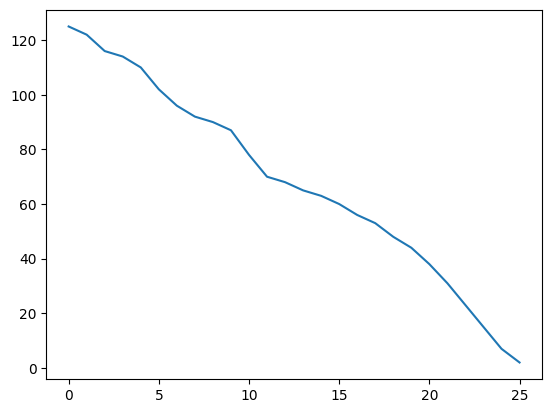

In [151]:
plt.plot(peaks[334//2][::-1])

In [152]:
peaks, _ = find_peaks(transposed[334//2])

In [153]:
peaks,  _

(array([  2,   7,  15,  23,  31,  38,  44,  48,  53,  56,  60,  63,  65,
         68,  70,  78,  87,  90,  92,  96, 102, 110, 114, 116, 122, 125],
       dtype=int64),
 {})

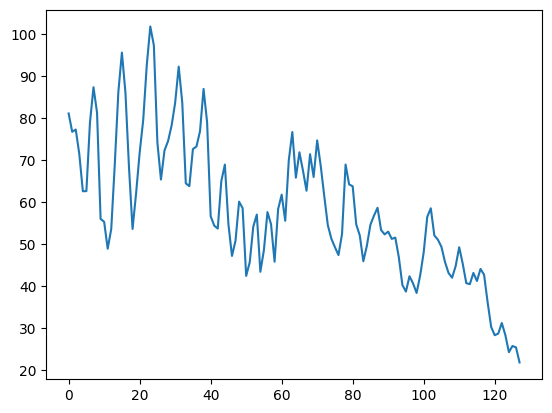

In [154]:
plt.plot(transposed[334//2])

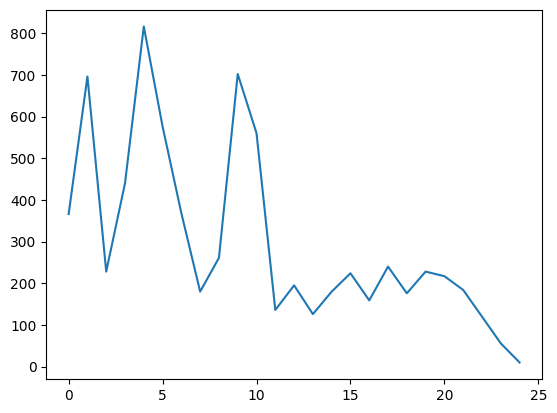

In [156]:
plt.plot(feature_ext_a)

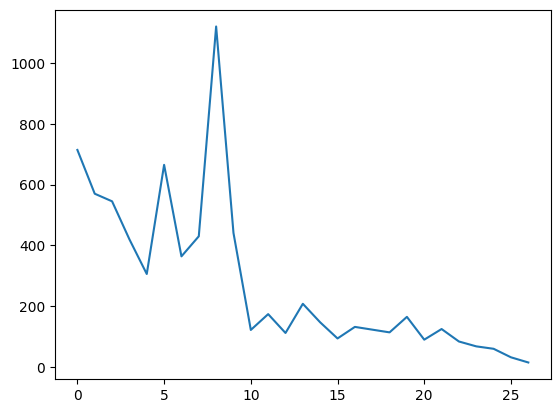

In [157]:
plt.plot(feature_ext)

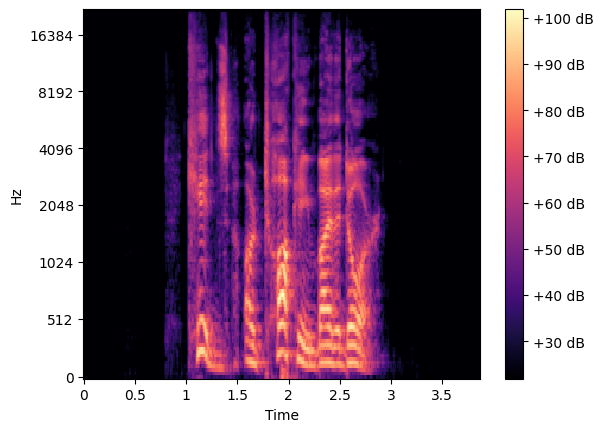

In [95]:
angry_specto = dict_emotion_arrs['angry'][0]
librosa.display.specshow(angry_specto, sr=44100, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

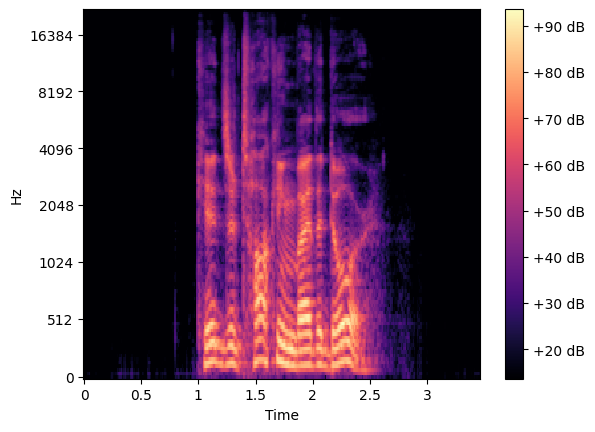

In [158]:
happy_specto = dict_emotion_arrs['happy'][0]
librosa.display.specshow(happy_specto, sr=44100, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

In [212]:
dist_a, peaks_a = find_peak_distances(middle_angry)

In [213]:
dist_h, peaks_h = find_peak_distances(middle_happy)

In [214]:
dist_a

array([6, 4, 2, 2, 4, 2, 4, 2, 2, 6, 5, 4, 3, 7, 4, 4, 5, 4, 5, 6, 6, 3,
       3, 2, 5, 2, 3, 3, 2, 4, 3])

In [215]:
dist_h

array([3, 4, 3, 4, 3, 4, 4, 3, 3, 4, 2, 2, 5, 7, 5, 5, 5, 3, 9, 4, 4, 3,
       4, 6, 2, 4, 3, 3, 4])

(array([8., 0., 6., 0., 8., 0., 4., 0., 4., 1.]),
 array([2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. , 6.5, 7. ]),
 <BarContainer object of 10 artists>)

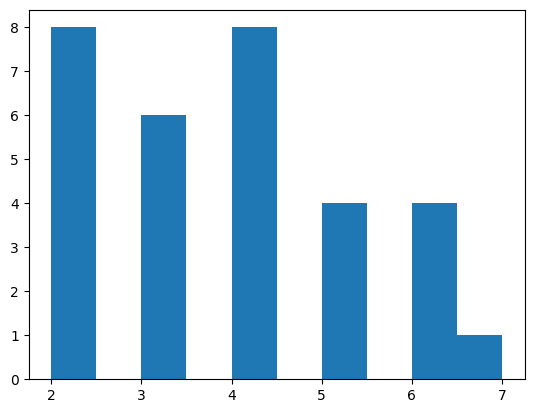

In [216]:
plt.hist(dist_a)

(array([ 3.,  9., 10.,  0.,  4.,  1.,  0.,  1.,  0.,  1.]),
 array([2. , 2.7, 3.4, 4.1, 4.8, 5.5, 6.2, 6.9, 7.6, 8.3, 9. ]),
 <BarContainer object of 10 artists>)

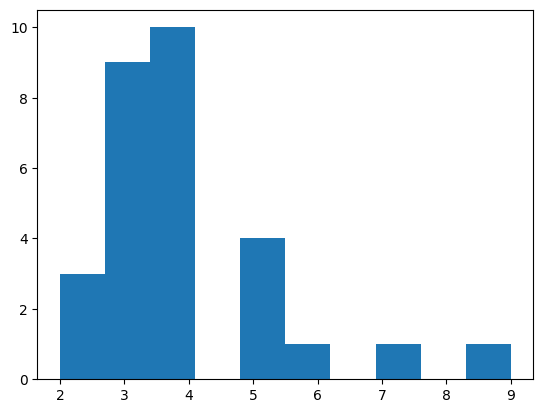

In [217]:
plt.hist(dist_h)